# Model Analysis & Diagnostics

This notebook explores the behavior of multiple deep learning models trained for dog breed classification:
- Custom CNN (VGG-style)
- ResNet-18
- Variational Autoencoder (VAE)
- Generative Adversarial Network (GAN)

The goal is to understand **why models perform the way they do**, not just report metrics.


## Dataset

- Task: Multi-class dog breed classification
- Number of classes: 15
- Input images resized to:
  - 128×128 (Custom CNN)
  - 224×224 (ResNet-18)

Data splits:
- Training set
- Validation set (used during training)
- Test set (held out for final evaluation)


In [36]:
import sys
import os

project_root = os.path.abspath("..")  # adjust if needed
if project_root not in sys.path:
    sys.path.append(project_root)

print(f"System path rooted at {project_root}")


System path rooted at /Users/jessica/papaya/Python/image_rec


In [40]:
# run main.py (training script) if no saved models are found
# if checkpoints is empty
if not os.listdir(os.path.join(project_root, "checkpoints")):
    os.system(f"{sys.executable} {os.path.join(project_root, 'main.py')}")

In [37]:
import torch
import torch.nn as nn
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np
import random

# import other file functions
import utils
import models
import eval
import checkpoints

## Training Dynamics

We compare training vs validation curves to detect:
- Overfitting
- Underfitting
- Optimization instability


Using device: mps

CNN Training Curves:


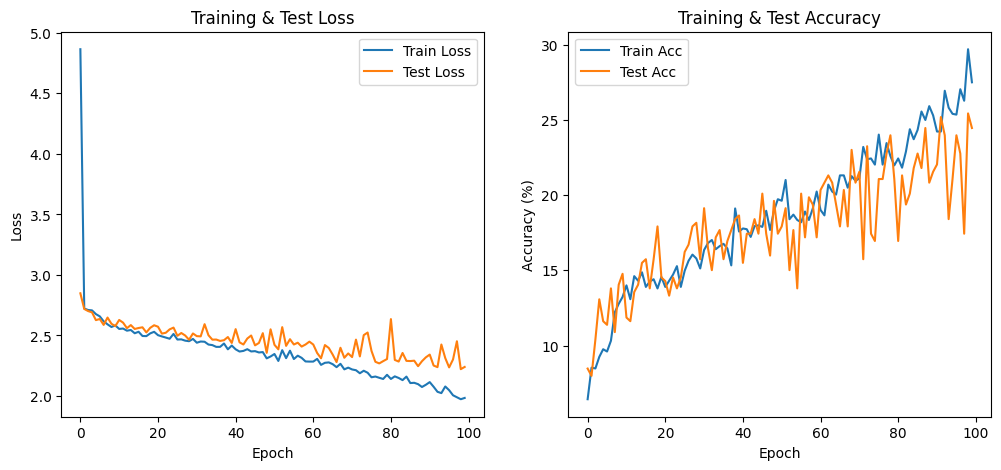


RESNET18 Training Curves:


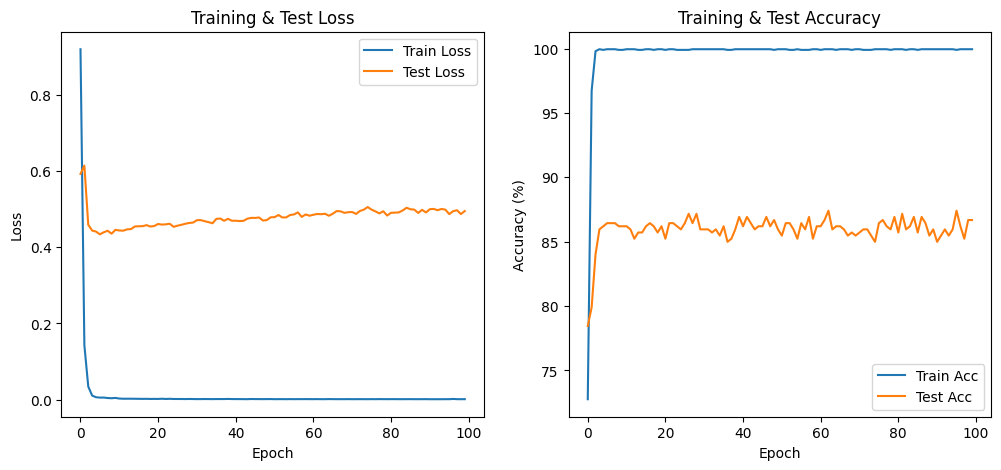

In [38]:

# load model in from checkpoints

from models.cnn import VGG11
from models.resnet import get_resnet18
from models.gan import ConvGenerator, ConvDiscriminator
from models.vae import ConvVAE


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

def load_models(num_classes):
    cnn = VGG11(num_classes=num_classes)
    cnn.load_state_dict(torch.load(f"{project_root}/checkpoints/cnn_model.pth", map_location=device))
    cnn.eval().to(device)

    resnet = get_resnet18(num_classes=num_classes)
    resnet.load_state_dict(torch.load(f"{project_root}/checkpoints/resnet18_model.pth", map_location=device))
    resnet.eval().to(device)

    gan_gen = ConvGenerator()
    gan_gen.load_state_dict(torch.load(f"{project_root}/checkpoints/gan_generator.pth", map_location=device))
    gan_gen.eval().to(device)

    gan_disc = ConvDiscriminator()
    gan_disc.load_state_dict(torch.load(f"{project_root}/checkpoints/gan_discriminator.pth", map_location=device))
    gan_disc.eval().to(device)

    vae = ConvVAE()
    vae.load_state_dict(torch.load(f"{project_root}/checkpoints/vae_model.pth", map_location=device))
    vae.eval().to(device)

    return cnn, resnet, gan_gen, gan_disc, vae  

def load_histories(path, device="cpu"):
    history = torch.load(path, map_location=device)
    train_loss_key, train_acc_key = list(history.keys())[0:2]
    val_loss_key, val_acc_key     = list(history.keys())[2:4]

    train_loss = history[train_loss_key]
    train_acc  = history[train_acc_key]
    val_loss   = history[val_loss_key]
    val_acc    = history[val_acc_key]

    # If any are tensors → convert to Python lists
    if torch.is_tensor(train_loss):
        train_loss = train_loss.cpu().tolist()
        train_acc  = train_acc.cpu().tolist()
        val_loss   = val_loss.cpu().tolist()
        val_acc    = val_acc.cpu().tolist()

    return train_loss, train_acc, val_loss, val_acc



from eval.eval import plot_curves

for model_name in ["cnn", "resnet18"]:
    train_loss, train_acc, val_loss, val_acc = load_histories(f"{project_root}/checkpoints/{model_name}_history.pt", device=device)
    print(f"\n{model_name.upper()} Training Curves:")
    plot_curves(train_loss, train_acc, val_loss, val_acc)


Observations:
- The custom CNN shows signs of underfitting early in training.
- ResNet-18 converges faster and generalizes better.
- Validation accuracy stabilizes earlier for pretrained models.


## Confusion Matrix Analysis

Confusion matrices help identify:
- Visually similar breeds
- Systematic misclassifications



CNN Confusion Matrix:


<Figure size 1200x1200 with 0 Axes>

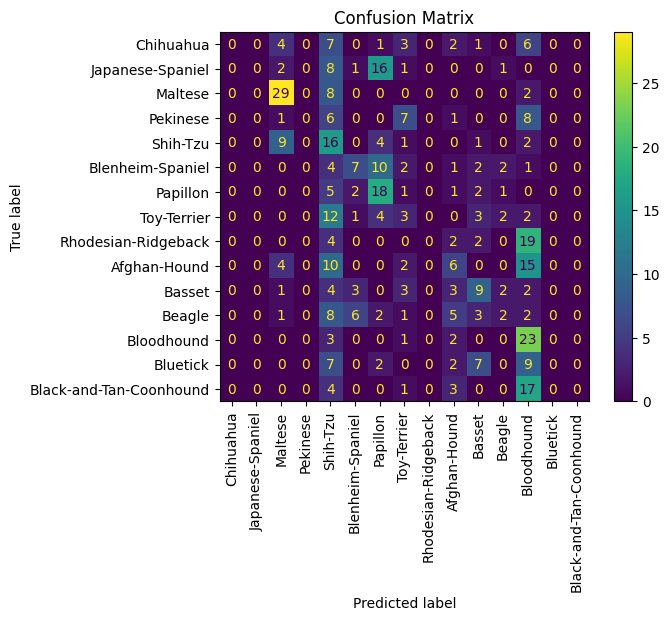


ResNet18 Confusion Matrix:


<Figure size 1200x1200 with 0 Axes>

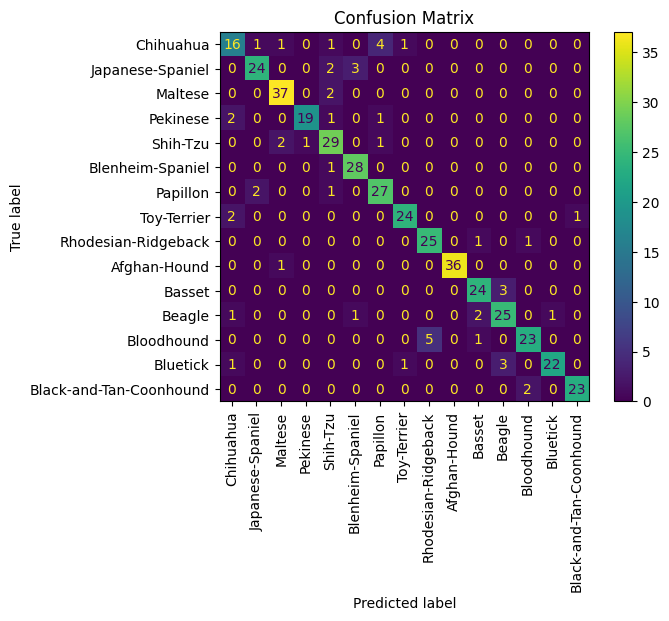

In [ ]:
from eval.eval import confusion_matrix_plot
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# class_names.txt
class_names = []
with open(os.path.join(project_root, f"{project_root}/class_names.txt"), "r") as f:
    for line in f:
        class_names.append(line.strip())
# Load test data
transform_small = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])

transform_large = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])

batch_size = 64

train_dataset = ImageFolder(f"{project_root}/data/dogs/train", transform=transform_small)
val_dataset   = ImageFolder(f"{project_root}/data/dogs/val",   transform=transform_small)
test_dataset  = ImageFolder(f"{project_root}/data/dogs/test",  transform=transform_small)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

train_dataset_large = ImageFolder(f"{project_root}/data/dogs/train", transform=transform_large)
val_dataset_large   = ImageFolder(f"{project_root}/data/dogs/val",   transform=transform_large)
test_dataset_large  = ImageFolder(f"{project_root}/data/dogs/test",  transform=transform_large)

train_loader_large = DataLoader(train_dataset_large, batch_size=batch_size, shuffle=True)
val_loader_large   = DataLoader(val_dataset_large,   batch_size=batch_size, shuffle=False)
test_loader_large  = DataLoader(test_dataset_large,  batch_size=batch_size, shuffle=False)

cnn, resnet, gan_gen, gan_disc, vae = load_models(num_classes=len(class_names))


print("\nCNN Confusion Matrix:")
confusion_matrix_plot(cnn, test_loader, device, class_names)
print("\nResNet18 Confusion Matrix:")
confusion_matrix_plot(resnet, test_loader_large, device, class_names)


## Misclassified Samples

Visual inspection of misclassified images reveals:
- Occlusion
- Unusual poses
- Low lighting


In [42]:
from eval.eval import show_misclassified
# cnn
print("\nCNN Misclassified Samples:")
show_misclassified(cnn, test_loader, device, class_names)
# resnet
print("\nResNet18 Misclassified Samples:")
show_misclassified(resnet, test_loader_large, device, class_names)



CNN Misclassified Samples:


RuntimeError: linear(): input and weight.T shapes cannot be multiplied (64x25088 and 8192x4096)